<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-функций-и-класса" data-toc-modified-id="Описание-функций-и-класса-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание функций и класса</a></span><ul class="toc-item"><li><span><a href="#Нормировка-массива-признаков" data-toc-modified-id="Нормировка-массива-признаков-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Нормировка массива признаков</a></span></li><li><span><a href="#Кросс-валидация" data-toc-modified-id="Кросс-валидация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Кросс-валидация</a></span></li><li><span><a href="#Класс-KNN" data-toc-modified-id="Класс-KNN-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Класс KNN</a></span></li></ul></li><li><span><a href="#Исследование" data-toc-modified-id="Исследование-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование</a></span><ul class="toc-item"><li><span><a href="#Применение-модели-к-датасету-при-варьировании-гиперпараметров" data-toc-modified-id="Применение-модели-к-датасету-при-варьировании-гиперпараметров-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Применение модели к датасету при варьировании гиперпараметров</a></span></li><li><span><a href="#Анализ-полученных-результатов" data-toc-modified-id="Анализ-полученных-результатов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Анализ полученных результатов</a></span></li></ul></li></ul></div>

# Классификация методом k-NN

Задача - написать класс KNN_classifier, пригодный для решения задачи классификации.
Для обработки данных напишем функцию, которая случайным образом разбивает выборку на train и test методом кросс-валидации (для исключения неудачного разбиения данных) и, используя класс KNN_classifier, оценивает точность прогнозирования методом k ближайших соседей с весом, обратно пропорциональным евклидовой норме.

В качестве функции близости используется Евклидово расстояние между объектами.

In [1]:
import numpy as np

## Описание функций и класса

### Нормировка массива признаков

In [2]:
def standard_scaler(X: np.array):
    
    """
    Стандартизует выборку по формуле x` = (x - x.mean()) / x.std() вдоль осей признаков.
    Получает на вход массив X размера [n_objects, n_features].
    Возвращает изменённый массив X размера [n_objects, n_features].
    """;
    
    def one_d_scaler(array: np.array) -> np.array:
        mean = array.mean()
        sigma = array.std()
        
        return (array - mean) / sigma
    
    return np.apply_along_axis(one_d_scaler, axis=0, arr=X)

### Кросс-валидация

In [3]:
def cross_val_score(clf, X: np.array, y: np.array, cv: int):
    
    """
    Разбивает случайным образом выборку (X, y) на cv (если cv > 1) частей и прогоняет её через объект класса clf.
    Если cv < 1, то cv используется, как доля выборки, отводящаяся под test. 
    Возвращает среднюю точность прогнозов.
    Точность определяется как доля правильных прогнозов.
    """;
    
    # Фиксируем seed, чтобы при каждом прогнозировании пары гиперпараметров k и alpha
    # использовалась одинаковая выборка train и test
    np.random.seed(42)
    
    X = standard_scaler(X)
    
    # Случайным образом перемешиваем входные массивы X и y
    
    # Ограничиваем длину массива до 10000
    length = min(10000, len(y))
    
    rand_seq = np.arange(length)
    np.random.shuffle(rand_seq)
    
    X_mixed = X[rand_seq]
    y_mixed = y[rand_seq]
    
    accuracies = []
    
    # Разбиваем полученные последовательности на фолды и обрабатываем их с помощью clf
    if cv > 1:
        q, e = divmod(length, cv)
        for i in range(cv):

            # Определяем фолды на train и test
            test_mask = np.full(length, False)
            test_mask[i*q+min(e, i):(i+1)*q+min(e, i+1)] = True

            X_test = X_mixed[test_mask]
            y_test = y_mixed[test_mask]
            X_train = X_mixed[~test_mask]
            y_train = y_mixed[~test_mask]

            # Передаём текущий набор фолдов в объект класса clf и возвращаем оценку точности
            clf.fit(X_train, y_train)
            accuracies.append((y_test == clf.predict(X_test)).mean())
    else:
        # Разделяем выюорку на train и test
        test_mask = np.full(length, False)
        test_mask[-int(cv*length):] = True
        
        X_test = X_mixed[test_mask]
        y_test = y_mixed[test_mask]
        X_train = X_mixed[~test_mask]
        y_train = y_mixed[~test_mask]

        # Передаём разделённую выборку в объект класса clf и возвращаем оценку точности
        #     (если не используется кросс-валидация)
        clf.fit(X_train, y_train)
        return (y_test == clf.predict(X_test)).mean()
    
    # Возвращаем среднюю оценку точности (если используется кросс-валидация)
    return (np.array(accuracies).mean())

### Класс KNN

In [4]:
class KNN_classifier:
    def __init__(self, n_neighbors: int, alpha=None):
        self.K = n_neighbors
        self.alpha = alpha
        
    def fit(self, x: np.array, y: np.array):
        
        """
        Сохраняет получаемую на вход тренировочную выборку и
        вычисляет массив сумм квадратов координат векторов X_train
        """;
        
        self.X_train = x
        self.y_train = y
        
        # Вычисляем сумму квадратов координат точек из train
        self.X_train_squared_norm = np.sum(np.square(self.X_train), axis=1)
        
        return

    def predict(self, x: np.array):
        
        """
        Предсказывает на основе метода k-NN класс точек, получаемых на вход, возвращая массив классов. 
        В качестве оценки расстояния используется квадрат евклидовой нормы, вычисляемой по формуле
            (a-b)^2 = a^2 + b^2 - 2*(a,b).
        Из полученной матрицы квадратов норм берёт наименьшие K значений и ищет среди них самый
            распространённый класс с учётом весов, который и будет предсказанием.
        Вес расчитывается как квадрат нормы в степени alpha. По умолчанию alpha = None, и расчёт проводится без весов.
        """;
        
        # Далее в комментариях для удобства указываются величины test, train и k.
        # train - число точек, попавших в обучающую выборку,
        # test - число точек, попавших в тестовую выборку.
        # k - параметр self.K, число ближайших соседей.
        
        predictions = []
        
        # Вычисляем квадраты норм разности для каждой пары train-test
        # Получися массив размера (test, train)
        self.M_squared = (
            np.sum(np.square(x), axis=1).reshape(-1, 1) 
            + self.X_train_squared_norm.reshape(1, -1) 
            - 2 * np.dot(x, self.X_train.transpose())
        )
        
        # Определяем индексы k ближайших точек
        # Получится массив размера (test, k)
        kindexes = self.M_squared.argpartition(range(self.K), axis=1)[:, :self.K]
        
        # Создаём массив, содержащий метки классов k ближайших точек
        # Получится массив размера (test, k)
        kclasses = self.y_train[kindexes]
        
        # Создаём массив, содержащий веса k ближайших точек
        # Получится массив размера (test, k)
        if self.alpha is not None:
            kweights = np.power(self.M_squared[(np.fromfunction(lambda i, j: i, (len(x), self.K), dtype=int)), kindexes],
                                     self.alpha)
        else:
            kweights = np.ones((len(x), self.K))
        
        # Находим среди ближайших соседей точки из test самый частый класс с учётом весов,
        #     который добавляем в список results
        # Обрабатываем таким образом все точки выборки test в цикле 
        results = []
        
        for i in range(len(x)):
            results.append(np.bincount(kclasses[i], weights=kweights[i]).argmax())
            
        return np.array(results)

In [5]:
from sklearn.datasets import fetch_covtype

import matplotlib.pyplot as plt

import tqdm

## Исследование

Цель исследования - подбор гиперпараметров, наилучшим образом позволяющих предсказывать класс объектов.  
Этими гиперпараметрами являются **n_neighbors** - число ближайших соседей и **alpha** - параметр весов. Напомним, что вес вычисляется как квадрат евклидового расстояния в степени alpha. 

Зафиксируем np.random.seed, чтобы при каждом прогнозировании пары гиперпараметров k и alpha использовалась одинаковая выборка train и test. Это позволит избежать хотя бы отчасти случайный фактор при выявлении зависимостей точности метода от гиперпараметров. 

### Применение модели к датасету при варьировании гиперпараметров 

In [6]:
X, y = fetch_covtype(return_X_y = True)

cv = 0.2
scores = {}

alphas = np.array(np.concatenate(([None], np.arange(-0.5, -3.1, -0.5))))
ks = range(1, 8)

for k in tqdm.tqdm(ks):
    scores[k] = []
    for alpha in alphas:
        kNN = KNN_classifier(n_neighbors=k, alpha=alpha)
        scores[k].append(cross_val_score(kNN, X, y, cv))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:49<00:00, 32.80s/it]


In [7]:
for k in scores:
    scores[k] = np.array(scores[k])
print(scores)

{1: array([0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905]), 2: array([0.7565, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905]), 3: array([0.775 , 0.788 , 0.793 , 0.7965, 0.7935, 0.7915, 0.7875]), 4: array([0.761 , 0.7825, 0.7905, 0.792 , 0.7955, 0.7955, 0.794 ]), 5: array([0.7635, 0.7835, 0.792 , 0.7945, 0.796 , 0.797 , 0.7945]), 6: array([0.753 , 0.782 , 0.7935, 0.7935, 0.7965, 0.797 , 0.7945]), 7: array([0.7495, 0.779 , 0.7925, 0.7935, 0.796 , 0.794 , 0.792 ])}


In [1]:
# Визуализируем результаты

alphas[0] = 0
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def draw():
    plt.grid()
    plt.ylabel("Точность модели")
    plt.xlabel("Гиперпараметр alpha")
    plt.title("Зависимость точности модели от гиперпараметров")
    plt.legend()
    plt.show()
    return

for key in scores.keys():
    plt.plot(alphas, scores[key], colors[key-1], label=f'k = {key}')

draw()

NameError: name 'alphas' is not defined

### Анализ полученных результатов

Рассмотрим график для cлучая $k=1$. Из него видно, что гиперпараметр $\alpha$ не влияет на результаты работы модели, что логично: $\alpha$ отвечает за веса среди ближайших точек. Какой вес ни давать единственной точке, результатом будет её класс. При $k=2$ результат будет совпадать с результатом при $k=1$, если использовать веса. Это также логично: при использовании весов ответом будет класс ближайшей точки, что то же самое, что определять класс по одной ближайшей точке.  
Указанные два факта косвенно подверждают адекватность работы модели.



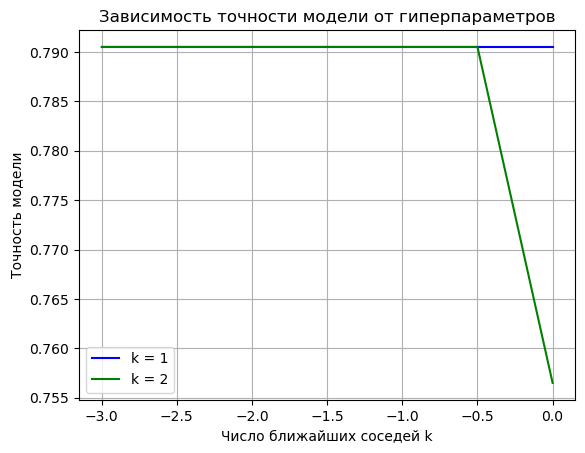

In [30]:
for key in range(1, 3):
    plt.plot(alphas, scores[key], colors[key-1], label=f'k = {key}')

draw()

В целом самые хорошие и стабильные результаты модель показала при параметрах $k\in \{1, 3, 5\}$. При этом разность в их точности остаётся в пределах менее 1%.

k = 1: 79.05%
k = 3: 79.65%
k = 5: 79.7%


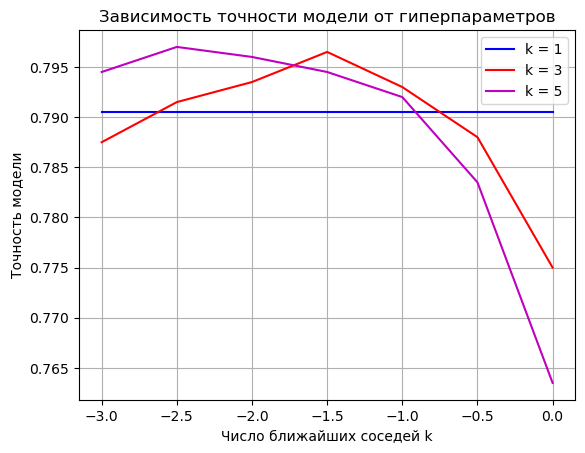

In [35]:
for key in [1, 3, 5]:
    plt.plot(alphas, scores[key], colors[key-1], label=f'k = {key}')
    print(f"k = {key}: {scores[key].max()*100}%")

draw()

Как итог, для данного датасета следует использовать модель с гиперпараметрами $(k = 3, \alpha = -1.5)$ или $(k = 5, \alpha = -2.5)$.